In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['11CA','total'])
    lista_ine2.append(ine_ods[date].loc['33PO','total'])
    lista_ine3.append(ine_ods[date].loc['026V','total'])
    lista_ine4.append(ine_ods[date].loc['21BU','total'])
    lista_ine5.append(ine_ods[date].loc['49GI','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,194
2020-04-02,183
2020-04-03,317
2020-04-04,177
2020-04-05,142


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,366.592593
std,108.663446
min,110.000000
25%,303.000000
50%,390.000000
75%,433.000000
max,614.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,276.233333
2020-05-31,402.096774
2020-06-30,447.100000


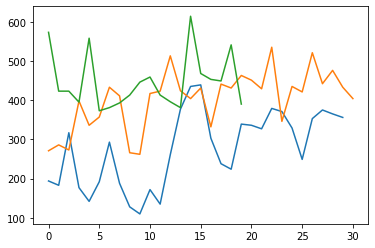

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
# cantidad de dias previos que se usaran para predecir el siguiente dia 
look_back=7

# convertir series en conocimiento supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia de entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia del pronostico (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # unimos todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # eliminamos todos los valores nulos
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# cargamos el dataframe en la variable values
values = df.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# imprimimos los nuevos datos
reframed.tail()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
76,0.202381,0.333333,0.384921,0.202381,0.134921,0.075397,1.000000,0.420635
77,0.333333,0.384921,0.202381,0.134921,0.075397,1.000000,0.420635,0.361111
78,0.384921,0.202381,0.134921,0.075397,1.000000,0.420635,0.361111,0.345238
79,0.202381,0.134921,0.075397,1.000000,0.420635,0.361111,0.345238,0.710318
80,0.134921,0.075397,1.000000,0.420635,0.361111,0.345238,0.710318,0.111111


# Dividimos los datos en sets de entrenamiento y validacion

In [16]:
# dividimos nuestro valores entre sets de entrenamiento y de test
values = reframed.values
n_train_days = 71 - (10+look_back)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# los volvemos a dividir en entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

# remodelamos la muestras para ser de las dimensiones [samples, timesteps, features]
trainX = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
testX = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(trainX.shape, y_train.shape, testX.shape, y_val.shape)

(54, 1, 7) (54,) (20, 1, 7) (20,)


# Creamos la red neuronal

In [17]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(look_back, input_shape=(1,look_back),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(100, activation='tanh'))
    model.add(Dropout(0.30))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [18]:
EPOCHS=200

model = crear_modeloFF()

history=model.fit(trainX,y_train,epochs=EPOCHS,validation_data=(testX,y_val),batch_size=look_back)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1

8/8 [==============================] - 0s 7ms/step - loss: 0.2320 - mse: 0.0881 - val_loss: 0.2500 - val_mse: 0.0962
Epoch 113/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2380 - mse: 0.0950 - val_loss: 0.2737 - val_mse: 0.1085
Epoch 114/200
8/8 [==============================] - ETA: 0s - loss: 0.3313 - mse: 0.161 - 0s 7ms/step - loss: 0.2335 - mse: 0.0930 - val_loss: 0.2561 - val_mse: 0.0983
Epoch 115/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2035 - mse: 0.0774 - val_loss: 0.2438 - val_mse: 0.0906
Epoch 116/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2281 - mse: 0.0896 - val_loss: 0.2226 - val_mse: 0.0874
Epoch 117/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1823 - mse: 0.0572 - val_loss: 0.2321 - val_mse: 0.0910
Epoch 118/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2049 - mse: 0.0758 - val_loss: 0.2407 - val_mse: 0.0901
Epoch 119/200
8/8 [==============================] - 0s 7ms

8/8 [==============================] - 0s 7ms/step - loss: 0.2143 - mse: 0.0750 - val_loss: 0.2662 - val_mse: 0.1015
Epoch 175/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2188 - mse: 0.0755 - val_loss: 0.2508 - val_mse: 0.0945
Epoch 176/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2382 - mse: 0.0869 - val_loss: 0.2494 - val_mse: 0.0952
Epoch 177/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2041 - mse: 0.0638 - val_loss: 0.2483 - val_mse: 0.0937
Epoch 178/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2069 - mse: 0.0641 - val_loss: 0.2439 - val_mse: 0.0915
Epoch 179/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1894 - mse: 0.0595 - val_loss: 0.2453 - val_mse: 0.0913
Epoch 180/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2164 - mse: 0.0813 - val_loss: 0.2592 - val_mse: 0.0971
Epoch 181/200
8/8 [==============================] - 0s 7ms/step - loss: 0.2016 - mse: 0.0655 - v

# Visualizamos resultados

In [19]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [20]:
# hacemos las predicciones
trainPredict = model.predict(x_train)
testPredict = model.predict(x_val)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = y_train.reshape(y_train.shape[0], 1)
trainY_scalerInverse = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = y_val.reshape(y_val.shape[0], 1)
testY_scalerInverse = scaler.inverse_transform(testY)

In [21]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse, trainPredict)
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse, testPredict)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 46.78 MAE
Resultado del entrenamiento: 4045.51 MSE
Resultado del entrenamiento: 63.60 RMSE
Resultado del entrenamiento: 17.84 CVRMSE
Resultado del entrenamiento: 14.87 MAPE 

Resultado del test: 67.97 MAE
Resultado del test: 6888.98 MSE
Resultado del test: 83.00 RMSE
Resultado del test: 18.56 CVRMSE
Resultado del test: 15.46 MAPE


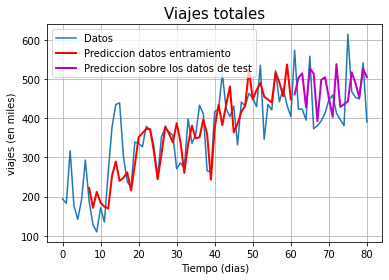

In [22]:
dataset = df.values
dataset = dataset.astype('float32')
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(df.values)
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

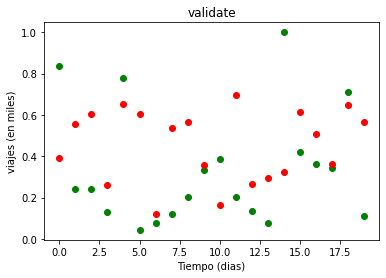

In [23]:
results=model.predict(x_val)

plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

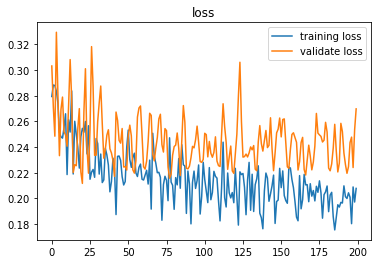

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

# Prediccion a futuro

In [25]:
# usaremos los 14 ultimos dias del confinamiento en junio para predecir como habrian sido los dias del 21 al 27 en caso de que
# el confinamiento se hubiese alargado por una semana mas

ultimosDias = df['2020-6-7':'2020-6-20']
ultimosDias

,Viajes
2020-06-07,381
2020-06-08,393
2020-06-09,413
2020-06-10,446
2020-06-11,459
2020-06-12,413
2020-06-13,396
2020-06-14,381
2020-06-15,614
2020-06-16,468


# Preparamos los datos para el test

In [26]:
# cargamos el dataframe en la variable values
values = ultimosDias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,-0.896996,-0.725322,-0.442060,-0.330472,-0.725322,-0.871245
8,-0.896996,-0.725322,-0.442060,-0.330472,-0.725322,-0.871245,-1.000000
9,-0.725322,-0.442060,-0.330472,-0.725322,-0.871245,-1.000000,1.000000
10,-0.442060,-0.330472,-0.725322,-0.871245,-1.000000,1.000000,-0.253219
11,-0.330472,-0.725322,-0.871245,-1.000000,1.000000,-0.253219,-0.381974
12,-0.725322,-0.871245,-1.000000,1.000000,-0.253219,-0.381974,-0.416309
13,-0.871245,-1.000000,1.000000,-0.253219,-0.381974,-0.416309,0.373391


In [27]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-0.87124467, -1.        ,  1.        , -0.25321865,
         -0.38197422, -0.41630888,  0.37339067]]], dtype=float32)

In [28]:
#definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

# Predicciones para la proxima semana

In [29]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.87124467 -1.          1.         -0.25321865 -0.38197422
   -0.41630888  0.37339067]]]
[[[-1.          1.         -0.25321865 -0.38197422 -0.41630888
    0.37339067 -0.03147242]]]
[[[ 1.         -0.25321865 -0.38197422 -0.41630888  0.37339067
   -0.03147242 -0.71001995]]]
[[[-0.25321865 -0.38197422 -0.41630888  0.37339067 -0.03147242
   -0.71001995  0.08231603]]]
[[[-0.38197422 -0.41630888  0.37339067 -0.03147242 -0.71001995
    0.08231603  0.16474226]]]
[[[-0.41630888  0.37339067 -0.03147242 -0.71001995  0.08231603
    0.16474226  0.03405607]]]
[[[ 0.37339067 -0.03147242 -0.71001995  0.08231603  0.16474226
    0.03405607 -0.5744319 ]]]


# Re-Convertimos los resultados

In [30]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.03147242], dtype=float32), array([-0.71001995], dtype=float32), array([0.08231603], dtype=float32), array([0.16474226], dtype=float32), array([0.03405607], dtype=float32), array([-0.5744319], dtype=float32), array([-0.08677928], dtype=float32)]


array([[493.83345825],
       [414.78267157],
       [507.08981337],
       [516.69246891],
       [501.46752731],
       [430.57867941],
       [487.39020913]])

# Visualizamos el pronostico

<AxesSubplot:>

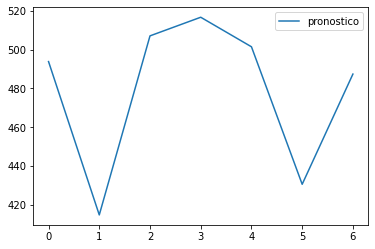

In [31]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()

# Prediccion con datos actuales

In [32]:
# usaremos 14 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-11':'2020-5-24']
Dias

,Viajes
2020-05-11,417
2020-05-12,423
2020-05-13,513
2020-05-14,424
2020-05-15,404
2020-05-16,431
2020-05-17,332
2020-05-18,441
2020-05-19,431
2020-05-20,463


# Preparamos los datos para el test

In [33]:
# cargamos el dataframe en la variable values
values = Dias.values

# convertimos los enteros en floats
values = values.astype('float32')

# normalizamos los datos a escala de entre -1 y 1
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

# usamos la funcion definida previamente
reframed = series_to_supervised(scaled, look_back, 1)

# eliminamos la ultima columna pues es parte de lo que queremos hayar
reframed.drop(reframed.columns[[7]], inplace=True, axis=1)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.162562,-0.103448,0.783251,-0.093596,-0.290641,-0.024631,-1.000000
8,-0.103448,0.783251,-0.093596,-0.290641,-0.024631,-1.000000,0.073892
9,0.783251,-0.093596,-0.290641,-0.024631,-1.000000,0.073892,-0.024631
10,-0.093596,-0.290641,-0.024631,-1.000000,0.073892,-0.024631,0.290640
11,-0.290641,-0.024631,-1.000000,0.073892,-0.024631,0.290640,0.172414
12,-0.024631,-1.000000,0.073892,-0.024631,0.290640,0.172414,-0.044335
13,-1.000000,0.073892,-0.024631,0.290640,0.172414,-0.044335,1.000000


In [34]:
values = reframed.values

#tomamos los valores para realizar el test
x_test = values[6:, :]

# reshape input to be 3D [samples, timesteps, features] - preguntar
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[-1.        ,  0.07389164, -0.02463055,  0.29064035,
          0.17241383, -0.04433489,  1.        ]]], dtype=float32)

In [35]:
#en la linea 24 definimos la funcion para realizar el desplazamiento que se hara en el array cada prediccion pues para hacer
#la siguiente prediccion eliminamos el dia mas antiguo, desplazamos un lugar el resto de dias y añadimos el ultimo dia que
#se ha predecido, esto es por que para predecir un dia se usan los 7 dias previos, y que usaremos a continuación

# Realizamos la prediccion 

In [36]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-1.          0.07389164 -0.02463055  0.29064035  0.17241383
   -0.04433489  1.        ]]]
[[[ 0.07389164 -0.02463055  0.29064035  0.17241383 -0.04433489
    1.         -0.08219397]]]
[[[-0.02463055  0.29064035  0.17241383 -0.04433489  1.
   -0.08219397  0.14967726]]]
[[[ 0.29064035  0.17241383 -0.04433489  1.         -0.08219397
    0.14967726 -0.07766937]]]
[[[ 0.17241383 -0.04433489  1.         -0.08219397  0.14967726
   -0.07766937  0.5916461 ]]]
[[[-0.04433489  1.         -0.08219397  0.14967726 -0.07766937
    0.5916461   0.44369733]]]
[[[ 1.         -0.08219397  0.14967726 -0.07766937  0.5916461
    0.44369733  0.14167753]]]


# Re-Convertimos los resultados

In [37]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)
inverted

[array([-0.08219397], dtype=float32), array([0.14967726], dtype=float32), array([-0.07766937], dtype=float32), array([0.5916461], dtype=float32), array([0.44369733], dtype=float32), array([0.14167753], dtype=float32), array([0.63835627], dtype=float32)]


array([[425],
       [449],
       [426],
       [494],
       [479],
       [448],
       [498]])

# Visualizamos el pronostico

<AxesSubplot:>

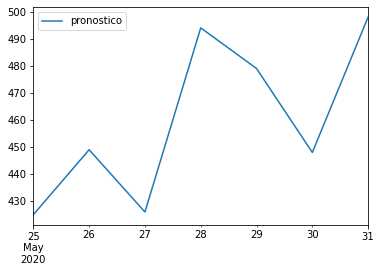

In [38]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [39]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']
compara

,real,prediccion
2020-05-25,435,425
2020-05-26,421,449
2020-05-27,521,426
2020-05-28,442,494
2020-05-29,476,479
2020-05-30,433,448
2020-05-31,404,498


<AxesSubplot:>

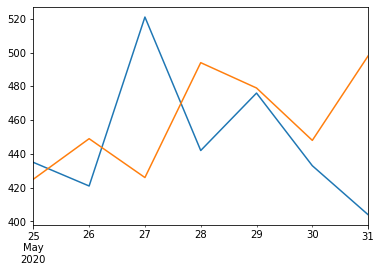

In [40]:
compara['real'].plot()
compara['prediccion'].plot()

In [41]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 42.43 MAE
Resultado del test: 3097.57 MSE
Resultado del test: 55.66 RMSE
Resultado del test: 12.10 CVRMSE
Resultado del test: 9.18 MAPE
